In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pipeline import main
from contextlib import redirect_stdout
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [88]:
RERUN_PIPELINE = False  # Set to True to rerun the pipeline and generate new data
SEED = 123

In [89]:
# run the pipeline to generate 500 records of data related to jonah hill which will be stored in the jonah_hill_data table
# also suppress all print statements from the pipeline
if RERUN_PIPELINE:
    with open(os.devnull, "w") as f, redirect_stdout(f):
        main(num_records=500, keywords=["jonah hill"], table_name="jonah_hill_data")

In [90]:
# read the data into a dataframe
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")
user = "celebrities_user"
password = POSTGRES_PASSWORD
host = "localhost"
port = "5432"
db = "celebrities_db"
df = pd.read_sql("SELECT * FROM jonah_hill_data", con=f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}")

In [91]:
df.head()

,url,url_mobile,title,seendate,socialimage,domain,language,sourcecountry,text,tags
0,https://pagesix.com/2025/10/14/celebrity-news/...,https://pagesix.com/2025/10/14/celebrity-news/...,jonah hill flaunts his thinnest physique yet o...,20251015T003000Z,https://pagesix.com/wp-content/uploads/sites/3...,pagesix.com,English,United States,jonah hill continued to show off his recent we...,"{""jonah hill""}"
1,https://www.hellomagazine.com/celebrities/8616...,https://www.hellomagazine.com/celebrities/8616...,jonah hill reveals his biggest transformation ...,20251015T004500Z,https://58v76y8z87lo.hellomagazine.com/horizon...,hellomagazine.com,English,United Kingdom,jonah hill has spent almost two decades in the...,"{""jonah hill""}"
2,https://pagesix.com/2025/10/10/celebrity-news/...,https://pagesix.com/2025/10/10/celebrity-news/...,jonah hill flaunts weight loss on set after de...,20251011T004500Z,https://pagesix.com/wp-content/uploads/sites/3...,pagesix.com,English,United States,jonah hill once again showed off his slimmed-d...,"{""jonah hill""}"
3,https://movieweb.com/jonah-hill-unrecognizable...,https://movieweb.com/jonah-hill-unrecognizable...,jonah hill is truly unrecognizable in first im...,20251222T193000Z,https://static0.moviewebimages.com/wordpress/w...,movieweb.com,English,United States,the word “unrecognizable” is thrown around a l...,"{""jonah hill""}"
4,https://tribune.com.pk/story/2573578/camila-ca...,https://tribune.com.pk/story/2573578/camila-ca...,camila cabello joins jonah hill and kristen wi...,20251022T024500Z,https://i.tribune.com.pk/media/images/cut-off1...,tribune.com.pk,English,Pakistan,us camila cabello and langston kerman join jon...,"{""jonah hill""}"


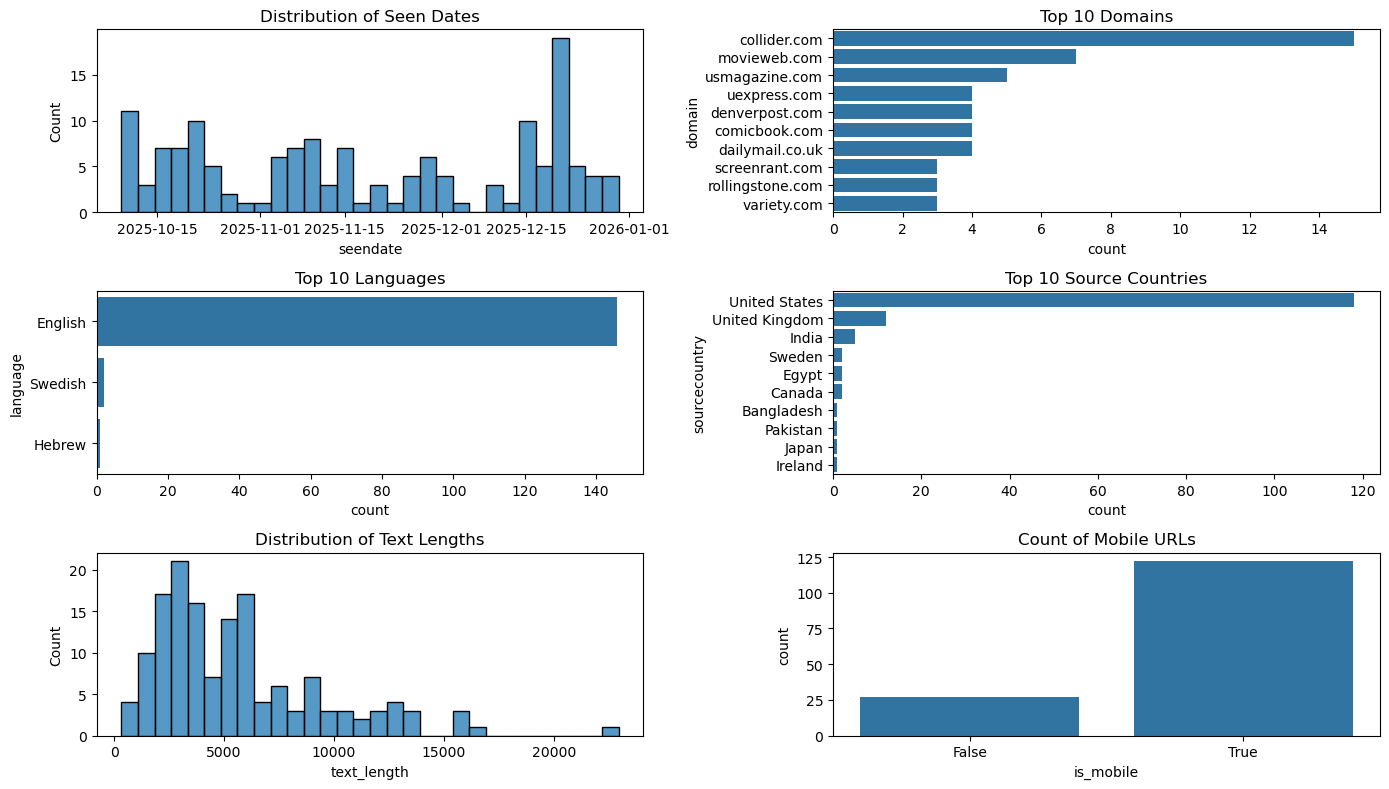

In [92]:
# basic EDA looking at seendate, domain, language, sourcecountry, text length, and url_mobile
fig, axes = plt.subplots(3, 2, figsize=(14, 8))

axes = axes.flatten()

df['seendate'] = pd.to_datetime(df['seendate'])
sns.histplot(df['seendate'], bins=30, ax=axes[0])
axes[0].set_title('Distribution of Seen Dates')

df['text_length'] = df['text'].apply(lambda x: len(x) if pd.notnull(x) else 0)
sns.countplot(y='domain', data=df, order=df['domain'].value_counts().index[:10], ax=axes[1])
axes[1].set_title('Top 10 Domains')

sns.countplot(y='language', data=df, order=df['language'].value_counts().index[:10], ax=axes[2])
axes[2].set_title('Top 10 Languages')

sns.countplot(y='sourcecountry', data=df, order=df['sourcecountry'].value_counts().index[:10], ax=axes[3])
axes[3].set_title('Top 10 Source Countries')

sns.histplot(df['text_length'], bins=30, ax=axes[4])
axes[4].set_title('Distribution of Text Lengths')

# count all instances where url = url_mobile
df['is_mobile'] = df.apply(lambda row: True if pd.notnull(row['url_mobile']) and row['url'] == row['url_mobile'] else False, axis=1)
sns.countplot(x='is_mobile', data=df, ax=axes[5])
axes[5].set_title('Count of Mobile URLs')


plt.tight_layout()

In [93]:
# basic logistic regression model to try to predict text_length based on other features
independent_vars = ['domain', 'language', 'sourcecountry', 'is_mobile']
# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_features = pd.DataFrame(encoder.fit_transform(df[independent_vars]), columns=encoder.get_feature_names_out(independent_vars))
target = df['text_length']
X_train, X_test, y_train, y_test = train_test_split(cat_features, target, test_size=0.2, random_state=SEED)
model = LogisticRegression(random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 23224299.5


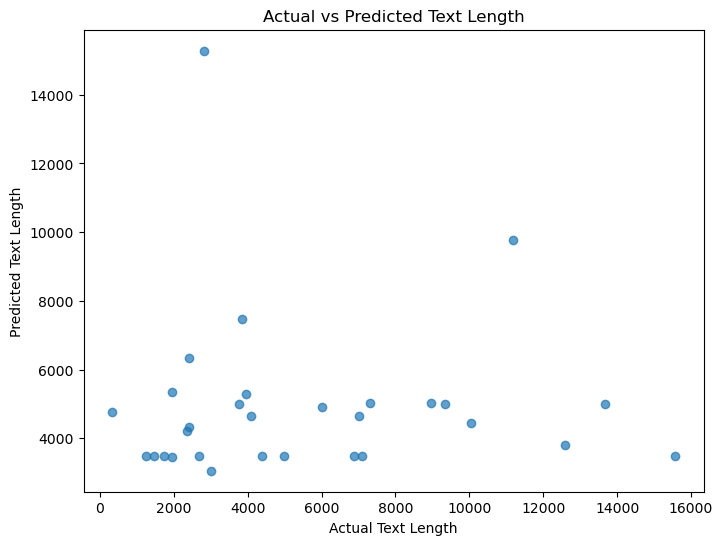

In [98]:
# plot the regression line for actual vs predicted text length
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Text Length')
plt.ylabel('Predicted Text Length')
plt.title('Actual vs Predicted Text Length')
plt.show()

In [95]:
# do some basic prediction models to try to predict text_length based on other features
independent_vars = ['domain', 'language', 'sourcecountry', 'is_mobile']

encoder = OneHotEncoder(sparse_output=False)
cat_features = pd.DataFrame(encoder.fit_transform(df[independent_vars]), columns=encoder.get_feature_names_out(independent_vars))

target = df['text_length']

X_train, X_test, y_train, y_test = train_test_split(cat_features, target, test_size=0.2, random_state=SEED)
model = RandomForestRegressor(random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 21542806.965866048


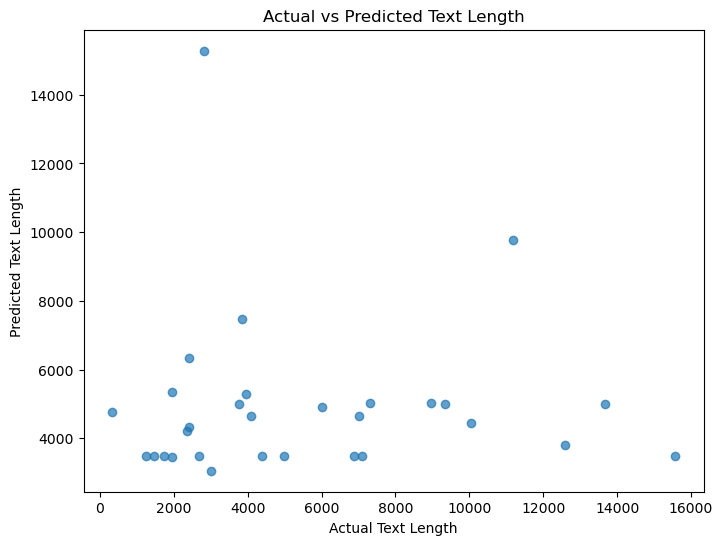

In [97]:
# plot the random forest regression line for actual vs predicted text length
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Text Length')
plt.ylabel('Predicted Text Length')
plt.title('Actual vs Predicted Text Length')
plt.show()

- Overall, the two models were very basic but they didn't do terrible. 
- They were able to predict the lower length texts decently by just basic categorical features, but struggled with longer texts. 
- Hyperparemeter tuning, more advanced models, and more feature would easily improve the performace.